# Udacity Excercise

 

Instructions:

- Gather necessary data to answer your questions

- Handle categorical and missing data

- Provide insight into the methods you chose and why you chose them

- Analyze, Model, and Visualize

- Provide a clear connection between your business questions and how the data answers them

- Communicate your business insights:

- Create a Github repository to share your code and data wrangling/modeling techniques, with a technical audience in mind

- Create a blog post to share your questions and insights with a non-technical audience


I decided to use the Airbnb dataset for different European cities. The dataset is collected by scrapping the web pages. The scrapping was done at different times. By downloading different dates, I can see how prices change over time. 

In [1]:
%matplotlib inline

In [2]:

import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

C:\Users\AJL\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
def get_url(city='berlin', date='2023-06-22', dataset='listings.csv.gz'):
    ''' Returns the URL to access the data on Airbnb.
        Params: 
            city (str): cityname
            date (str): in Format 2023-06-22
            dataset (str): airbnb dataset, i.e. listings.csv.gz
    
    '''
    cities_to_region = {'amsterdam': 'the-netherlands/north-holland/amsterdam',
                       'athens': 'greece/attica/athens',
                       'barcelona': 'spain/catalonia/barcelona',
                       'berlin': 'germany/be/berlin'}
    # The links are always build the same way.

    #http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2023-09-03/data/listings.csv.gz
    region = cities_to_region[city]
    return f'http://data.insideairbnb.com/{region}/{date}/data/{dataset}'

In [4]:
# For specified dates the website was scraped. You cannot query all dates. Here we have written down the dates where Airbnb has data
# This was done by looking at the homepage http://insideairbnb.com/get-the-data/
cities_to_valid_dates = {'amsterdam': ['2023-09-03', '2023-06-05', '2023-03-09', '2022-12-05'],
                         'athens': ['2023-06-25', '2023-03-27', '2022-12-27', '2022-09-20'],
                         'barcelona': ['2023-06-10', '2023-03-14', '2022-12-11'],
                         'berlin': ['2023-06-22', '2023-03-19', '2022-12-21', '2022-09-15']
}

all_cities = cities_to_valid_dates.keys()

In [5]:

# code to save images to image folder
image_dir = 'images/'
os.makedirs(image_dir, exist_ok=True)
def save_img(name):
    plt.savefig(os.path.join(image_dir, f'{name}.png'.replace(' ', '_').lower()), bbox_inches='tight')



In [6]:
datasets = ['listings.csv.gz', 'calendar.csv.gz']#,'listings.csv', 'reviews.csv',  'reviews.csv.gz']
data_dir = 'data/'
os.makedirs(data_dir, exist_ok=True)



def get_filename(city, date, dataset):
    ''' Returns the name of the file where
        the data for city, date, dataset is stored
    
    '''
    
    return os.path.join(data_dir, f'{city}_{date}_{dataset}')

In [7]:
def download_file(url, filename):
    ''' Download url from internet and save to filename
        Does skip the download if data already exists.
    
    '''
    if os.path.exists(filename):
        # Save data volume if file exists
        print(f"File already there {filename}")
        return
    response = requests.get(url)
    with open(filename, mode="wb") as file:
        file.write(response.content)
    print(f"Downloaded file {url} to {filename}")

 


In [8]:
raw_data = dict()
for city, dates in cities_to_valid_dates.items():
    for date in dates:
        for data in datasets:
            url = get_url(city, date, data)
            file_name = get_filename(city, date, data)
            download_file(url, file_name)
            
            raw_data[(city, date, data)] = pd.read_csv(file_name)

File already there data/amsterdam_2023-09-03_listings.csv.gz
File already there data/amsterdam_2023-09-03_calendar.csv.gz
File already there data/amsterdam_2023-06-05_listings.csv.gz
File already there data/amsterdam_2023-06-05_calendar.csv.gz
File already there data/amsterdam_2023-03-09_listings.csv.gz
File already there data/amsterdam_2023-03-09_calendar.csv.gz
File already there data/amsterdam_2022-12-05_listings.csv.gz
File already there data/amsterdam_2022-12-05_calendar.csv.gz
File already there data/athens_2023-06-25_listings.csv.gz
File already there data/athens_2023-06-25_calendar.csv.gz
File already there data/athens_2023-03-27_listings.csv.gz
File already there data/athens_2023-03-27_calendar.csv.gz
File already there data/athens_2022-12-27_listings.csv.gz
File already there data/athens_2022-12-27_calendar.csv.gz
File already there data/athens_2022-09-20_listings.csv.gz
File already there data/athens_2022-09-20_calendar.csv.gz
File already there data/barcelona_2023-06-10_lis

In [9]:
def clean_price(x):
    ''' Prices come with a $ sign.
        If thousands are present the , is used.
        These method transforms them to float.
    '''
    if isinstance(x, float):
        return x
    assert '$' in x
    return float(x.replace('$', '').replace(',', ''))

def clean_amenities(x):
    ''' Remove unnessary chars [, ", ] from x.

    '''
    for s in ['"', '[', ']', "'"]:
        x = x.replace(s, '')
    return x.strip()

In [10]:
ams_202309 = raw_data[('amsterdam',  '2023-09-03',  'listings.csv.gz')]
# We want to look at the most used amenities only. We check the most used in Amsterdam and look for the precence of them
# Only in Amsterdam 2023-09-03 there are 2228 different amenities, some of them only appear once
amenities = ams_202309['amenities'].apply(lambda x: x.split(','))
amenities = amenities.apply(lambda x: [clean_amenities(i) for i in x])
most_used_amenities = pd.Series(amenities.sum()).value_counts().head(30)


In [11]:
# Number of bedrooms is often missing, although number of beds is indicated
# We proceed as follows: Look at data where both beds and bedrooms is available
# Use the median number of bedrooms for a given number of beds.

print(ams_202309[['beds', 'bedrooms']].isnull().sum())
map_beds_to_bedrooms = ams_202309[['beds', 'bedrooms']].dropna().groupby('beds').median().squeeze()

beds          73
bedrooms    1428
dtype: int64


In [12]:
map_beds_to_bedrooms

beds
1.0      1.0
2.0      2.0
3.0      3.0
4.0      3.0
5.0      3.0
6.0      3.0
7.0      4.0
8.0      4.0
11.0     5.0
12.0     3.0
13.0     3.0
14.0     5.0
16.0     5.0
17.0     5.0
20.0     6.5
22.0     7.5
24.0     8.0
26.0    10.0
30.0    17.0
33.0    10.0
Name: bedrooms, dtype: float64

In [13]:
def process_listings(df_raw):
    ''' Processes the listings dataframe, 
    i.e. extracts and transforms the columns we want to use for the analysis, handles missing values
    and categorical variables.
    
    '''
    
    df_clean = pd.DataFrame()

    for c in ['id', 'neighbourhood_cleansed', 'bedrooms', 
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'latitude', 'longitude',
              'number_of_reviews',
             'review_scores_rating']:
        df_clean[c] = df_raw[c]

        
    # Number of bedrooms is often missing, although number of beds is indicated
    # We proceed as follows: Look at data where both beds and bedrooms is available
    # Use the median number of bedrooms for a given number of beds.
    map_beds_to_bedrooms = df_raw[['beds', 'bedrooms']].dropna().groupby('beds').median().squeeze()
    df_clean['bedrooms'].fillna(df_raw['beds'].apply(lambda x: map_beds_to_bedrooms.get(x, np.nan)), inplace=True)
    
    # amenities data comes as a string with the notation of a list.
    # we need to have dummy variables (i.e. has_wifi) and only want to look
    # at the 30 most used attributes.
    amenities = df_raw['amenities'].apply(lambda x: x.split(','))
    amenities = amenities.apply(lambda x: [clean_amenities(i) for i in x])
    amenities = amenities.to_frame()

    for x in most_used_amenities.index:
        df_clean['has_'+x.lower().replace(' ', '_')] = amenities['amenities'].apply(lambda c: x in c)
    
    
    # price data has wrong format (string instad of float)
    df_clean['price'] = df_raw['price'].apply(clean_price)
    
    # compute price per room
    df_clean['price per room'] = df_clean['price']/df_clean['bedrooms']
    
    return df_clean.set_index('id')
    

date
2022-12-11    10030
2022-12-12    15777
2022-12-13    15777
2022-12-14    15777
2022-12-15    15777
              ...  
2023-12-07    15762
2023-12-08    15762
2023-12-09    15762
2023-12-10    15762
2023-12-11     5752
Name: listing_id, Length: 366, dtype: int64

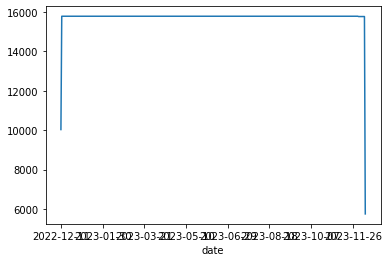

In [14]:
# the following data demonstrates that because of the scraping process, the first and last date is often imcompletely
# sampled.
# we drop those dates later on. Here we only illustrate the point
sample_calendar = raw_data[('barcelona',  '2022-12-11',  'calendar.csv.gz')]

sample_calendar.groupby('date')['listing_id'].count().plot()
sample_calendar.groupby('date')['listing_id'].count()

In [15]:
def process_calendar(df_raw):
    ''' Processes the calendar dataframe, 
    i.e. extracts and transforms the columns we want to use for the analysis, handles missing values.
    
    '''
    df_clean = pd.DataFrame()
    # data errors
    # These entries do not have a price but the announcement is availabe at the date -> data error.
    # Should be discareded.
    invalid = ((df_raw['price'].isnull()) & (df_raw['available']=='t'))
    
    
    
    df_clean['price'] = df_raw['price'].apply(clean_price)
    # convert to timestamp
    df_clean['date'] = df_raw['date'].apply(lambda x: pd.Timestamp(x))
    # Make a bool
    df_clean['available'] = df_raw['available'].apply(lambda x: True if x=='t' else False)
    
    # remove invalid entries, see above
    df_clean.loc[invalid, 'available'] = False
    df_clean['id'] = df_raw['listing_id']
    
    # remove first and last dates as explained above.
    q = df_clean.groupby('date')['id'].count().quantile(0.25)
    valid_dates = (df_clean.groupby('date')['id'].count()>=q)
    valid_dates = valid_dates[valid_dates].index
    df_clean = df_clean.query('date in @valid_dates')


    return df_clean.set_index('id')

In [16]:
listings = dict()
calendars = dict()

for (city, date, dataset), df_raw in raw_data.items():
    if dataset=='listings.csv.gz':
        listings[(city, date)] = process_listings(df_raw)
    elif dataset == 'calendar.csv.gz':
        calendars[(city, date)] = process_calendar(df_raw)
    else:
        print(f'Unkown dataset {dataset}')


In [17]:
del raw_data # free up memory

In [18]:
def get_latest_date(city='berlin'):
    ''' Returns the most recent dataset available for a given city
    '''
    return max(filter(lambda x: x[0] == city, listings.keys()))[1]

# Seasonality

In [19]:
calendars.keys()

dict_keys([('amsterdam', '2023-09-03'), ('amsterdam', '2023-06-05'), ('amsterdam', '2023-03-09'), ('amsterdam', '2022-12-05'), ('athens', '2023-06-25'), ('athens', '2023-03-27'), ('athens', '2022-12-27'), ('athens', '2022-09-20'), ('barcelona', '2023-06-10'), ('barcelona', '2023-03-14'), ('barcelona', '2022-12-11'), ('berlin', '2023-06-22'), ('berlin', '2023-03-19'), ('berlin', '2022-12-21'), ('berlin', '2022-09-15')])

In [20]:
key = ('amsterdam', '2023-09-03')

In [21]:
def compute_median_price(city, date, available=True):
    if available == 'all':
        return calendars[(city, date)].reset_index().groupby('date')['price'].median()
    elif available == True:
        return calendars[(city, date)].reset_index().query('available == True').groupby('date').median()['price']
    else:
        assert available == False
        return calendars[(city, date)].reset_index().query('available == False').groupby('date').median()['price']

    

In [22]:
def compute_availability(city, date, available=True):
        return calendars[(city, date)].reset_index().groupby('date')['available'].mean()
  

In [23]:
median_prices = dict()
for city, date in calendars.keys():
    median_prices[(city, date)] = compute_median_price(city, date, available=True)
median_prices = pd.DataFrame(median_prices)

In [24]:
availability = dict()
for city, date in calendars.keys():
    availability[(city, date)] = compute_availability(city, date, available=True)
availability = pd.DataFrame(availability)

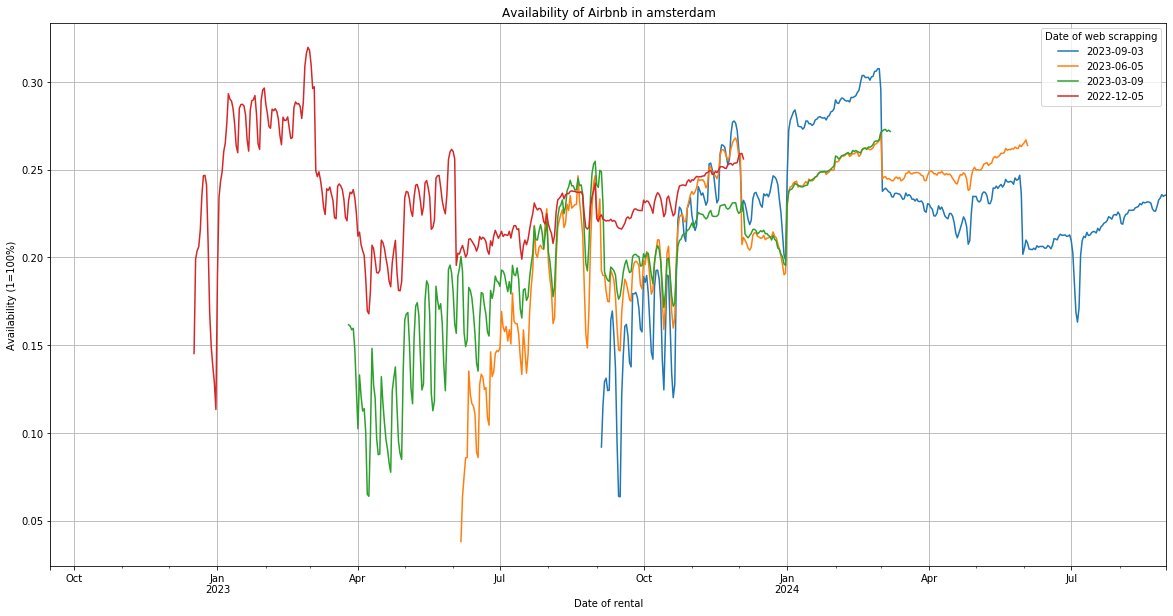

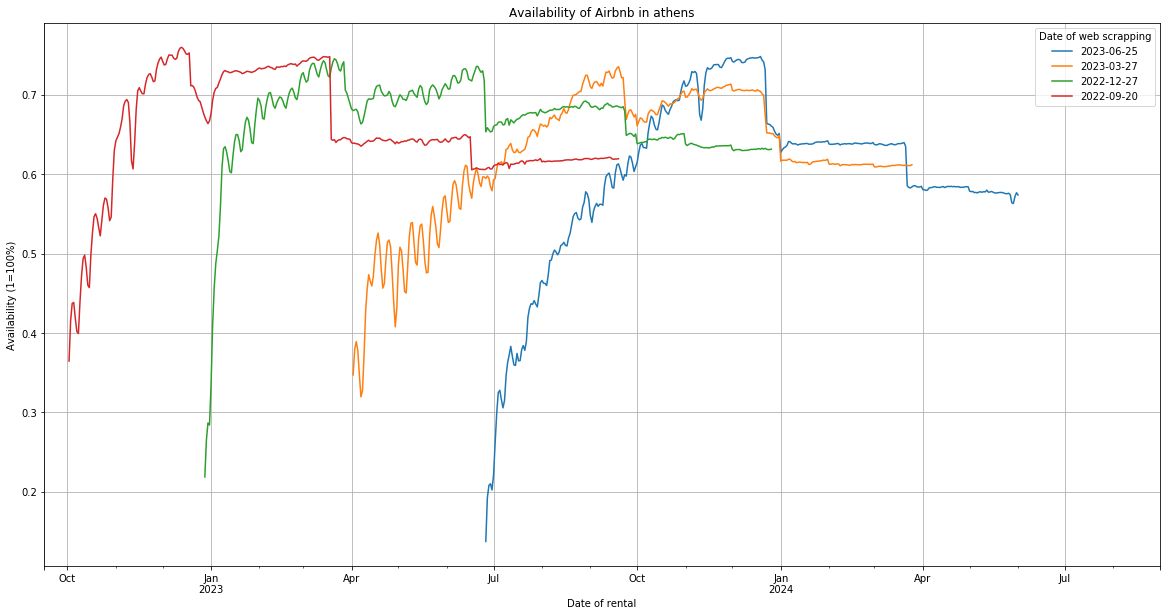

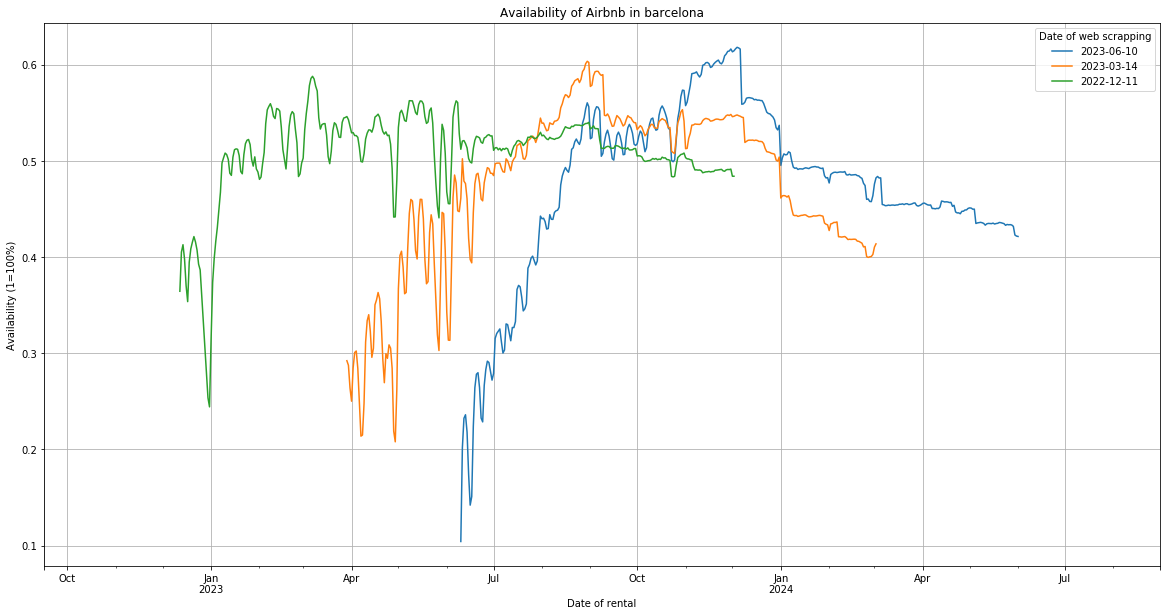

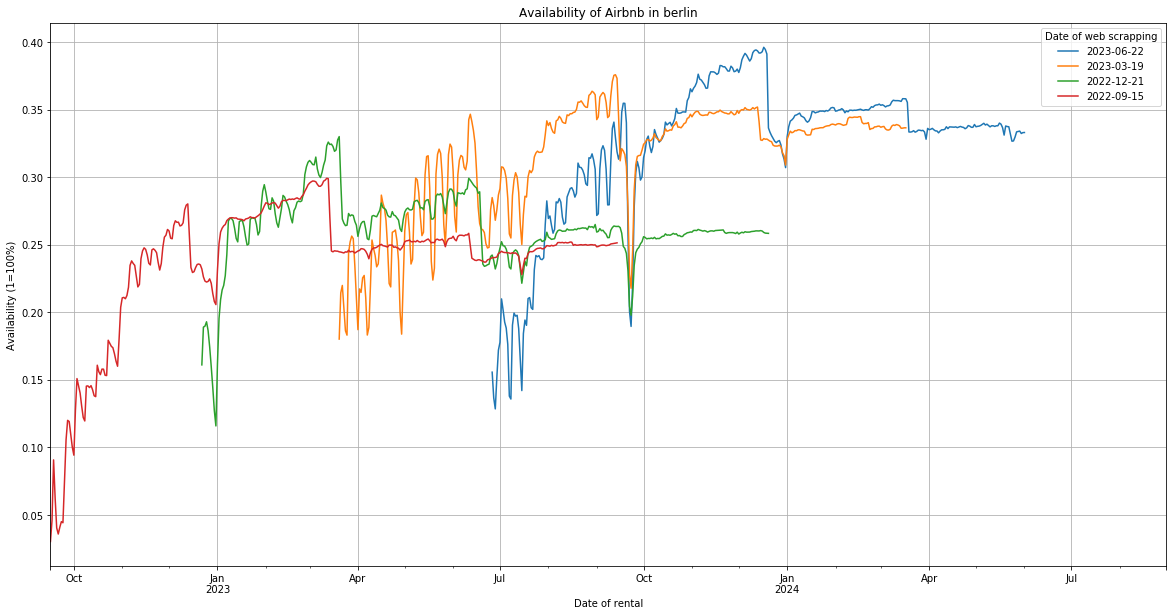

In [25]:
for city in all_cities:
    dat =availability.xs(city, axis=1, level=0)
    dat.columns.name = 'Date of web scrapping'
    title=f'Availability of Airbnb in {city}'
    dat.plot(figsize=(20, 10), title=title)
    plt.gca().grid()
    plt.ylabel('Availability (1=100%)')
    plt.xlabel('Date of rental')
    save_img(title)

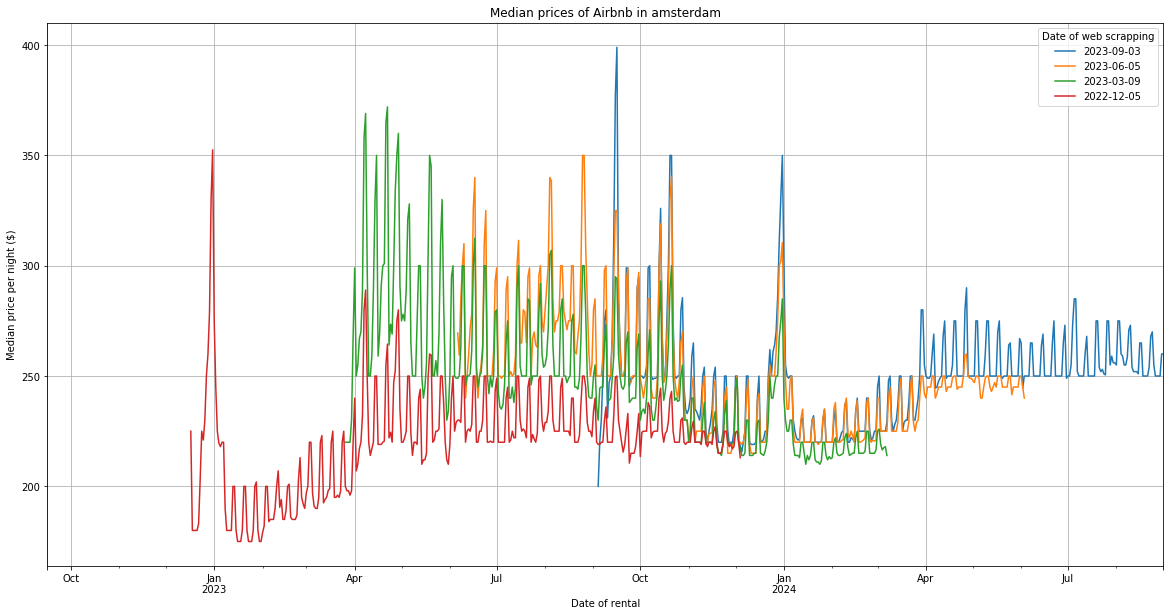

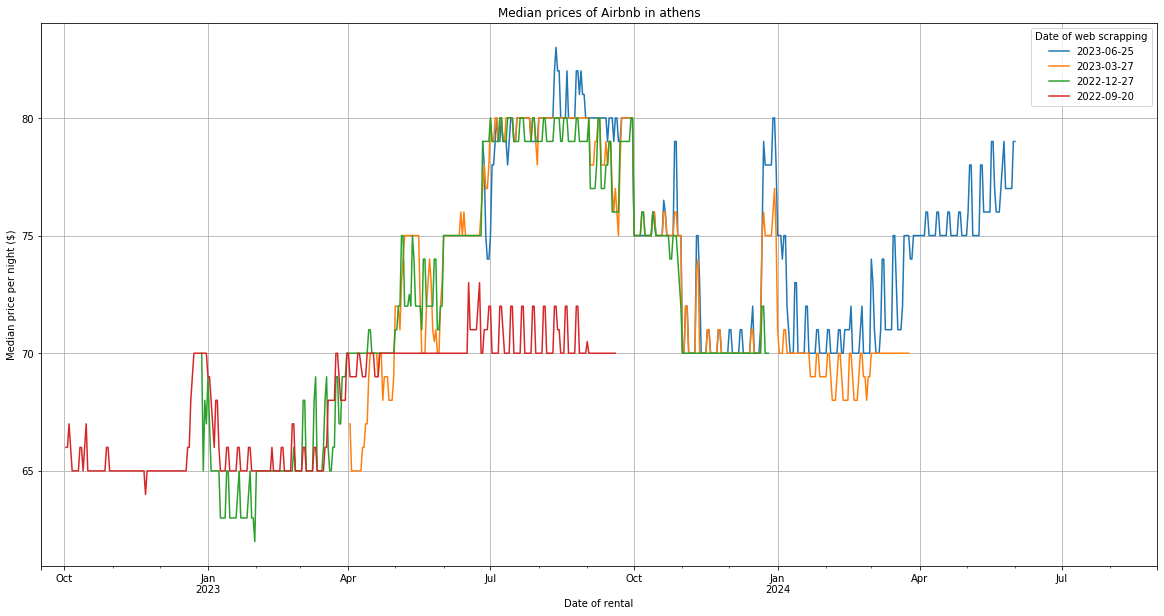

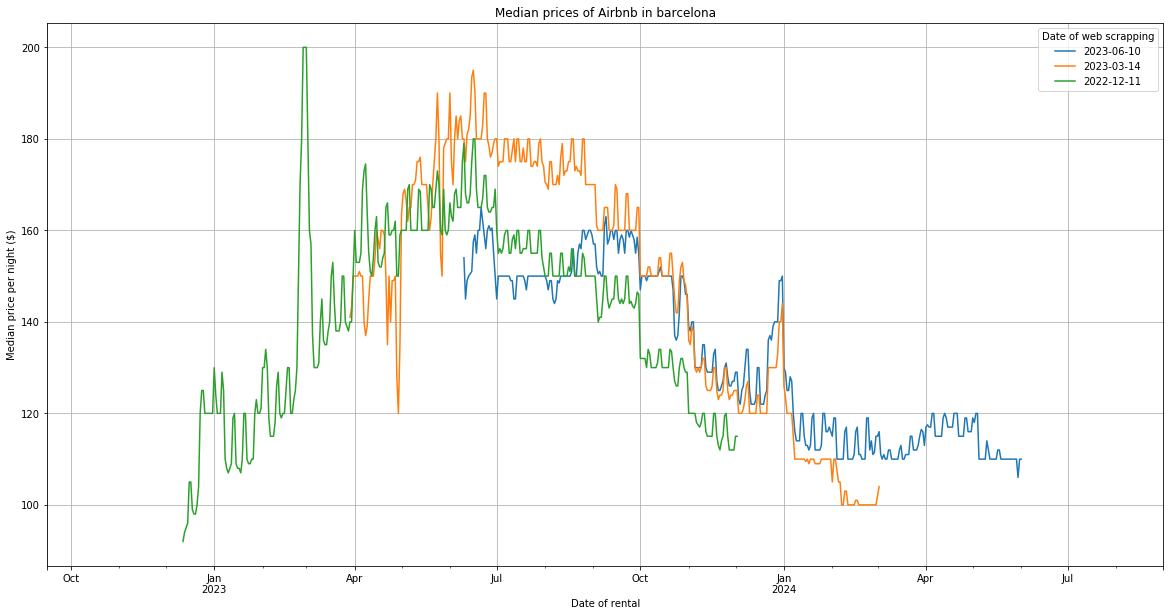

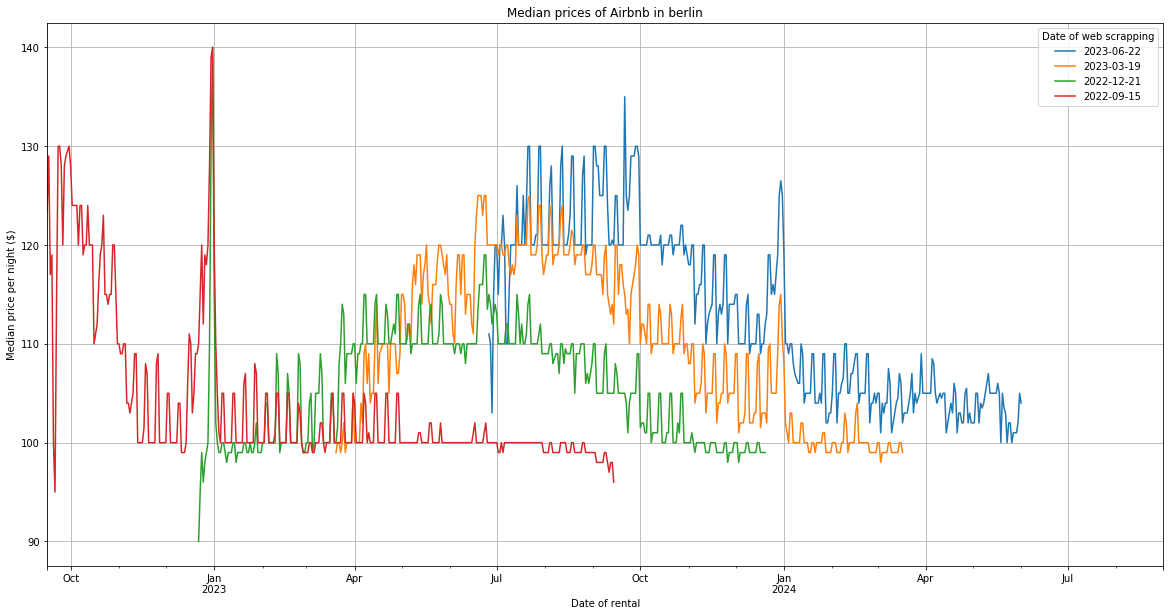

In [26]:
for city in all_cities:
    dat =median_prices.xs(city, axis=1, level=0)
    dat.columns.name = 'Date of web scrapping'
    title=f'Median prices of Airbnb in {city}'
    dat.plot(figsize=(20, 10), title=title)
    plt.gca().grid()
    plt.ylabel('Median price per night ($)')
    plt.xlabel('Date of rental')
    save_img(title)

# Dynamic pricing

In [27]:

res = dict()
for city in all_cities:
    key =  (city, get_latest_date(city))

    res[city] = calendars[key].groupby('id').apply(lambda x: len(x['price'].value_counts()))

In [28]:
(pd.DataFrame(res)).describe(i/10 for i in range(10)).iloc[4:]

,amsterdam,athens,barcelona,berlin
0%,1.0,1.0,1.0,1.0
10%,1.0,1.0,1.0,1.0
20%,1.0,2.0,1.0,1.0
30%,1.0,2.0,1.0,1.0
40%,2.0,3.0,2.0,1.0
50%,2.0,5.0,4.0,2.0
60%,3.0,6.0,6.0,3.0
70%,5.0,8.0,8.0,6.0
80%,9.0,11.0,14.0,10.0
90%,26.0,23.0,40.0,19.0


# Maps

In [29]:
def draw_map(city='berlin', date='last', concept='mean', variable='price', winsorize=0):
    if date == 'last':
        date = get_latest_date(city)
    key =  (city, date)

    geo = listings[key][['longitude', 'latitude', variable]]

    geo.columns = ['x', 'y', 'z']

    N = 2
    geo['x'] = (N*geo['x']/geo['x'].std()).astype(int)*geo['x'].std()/N
    geo['y'] = (N*geo['y']/geo['y'].std()).astype(int)*geo['y'].std()/N
    
    if winsorize:
        assert winsorize<0.5
        geo['z'] = geo['z'].clip(upper=geo['z'].quantile(1-winsorize), lower=geo['z'].quantile(winsorize))



    if concept == 'mean':
        to_draw = geo.groupby(['x', 'y']).mean()['z'].unstack().T.sort_index(ascending=False)
    elif concept == 'count':
        to_draw = geo.groupby(['x', 'y']).count()['z'].unstack().T.sort_index(ascending=False)
    elif concept == 'median':
        to_draw = geo.groupby(['x', 'y']).median()['z'].unstack().T.sort_index(ascending=False)        
    else:
        raise Exception('unknown concept')


    sns.heatmap(to_draw, cmap="coolwarm")
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter(''))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter(''))

In [30]:
for city in all_cities:
    draw_map(city=city, concept='median', variable='price per room' ,winsorize=0.05)
    title = f'Median price per room in {city}'
    plt.suptitle(title)
    save_img(title)
    plt.close()

C:\Users\AJL\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\AJL\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\AJL\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [31]:
for city in all_cities:
    draw_map(city=city, concept='count', variable='price' ,winsorize=None)
    title = f'Location of Airbnbs  in {city}'
    plt.suptitle(title)
    save_img(title)
    plt.close()

C:\Users\AJL\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\AJL\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [32]:
res = dict()
for city in all_cities:
    lis = listings[(city, get_latest_date(city))]
    lis.groupby('neighbourhood_cleansed')['price'].median().sort_values().plot(kind='bar', figsize=(20, 10))
    title = f'Median price per room in {city} by neighboorhood'
    plt.suptitle(title)
    save_img(title)
    plt.close()

In [33]:
res = dict()
for city in all_cities:
    res[city] = listings[city, get_latest_date(city)].groupby('bedrooms')['price'].median()
# unsual data for flat with more than 6 rooms
pd.concat(res, axis=1).dropna().loc[:6].plot
title = 'Price of flat by number of bedrooms'
plt.ylabel('Price of flat')
plt.suptitle(title)
save_img(title)
plt.close()

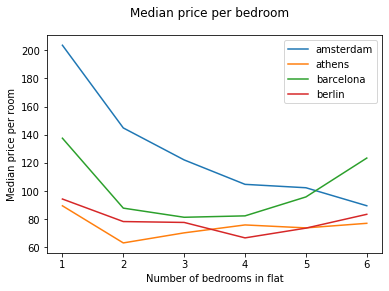

In [34]:
res = dict()
for city in all_cities:
    res[city] = listings[city, get_latest_date(city)].groupby('bedrooms')['price per room'].mean()
pd.concat(res, axis=1).dropna().loc[:6].plot()
title = 'Median price per bedroom'
plt.ylabel('Median price per room')
plt.xlabel('Number of bedrooms in flat')

plt.suptitle(title)
save_img(title)


In [35]:
res = dict()
for city in all_cities:
    res[city] = listings[city, get_latest_date(city)]['price'].median()
pd.Series(res)#.dropna().plot()

amsterdam    207.0
athens        73.0
barcelona    111.0
berlin        81.0
dtype: float64

In [36]:
res = dict()
for city in all_cities:
    res[city] = listings[city, get_latest_date(city)]['price per room'].median()
pd.Series(res)#.dropna().plot()

amsterdam    150.0
athens        58.5
barcelona     70.5
berlin        69.5
dtype: float64

In [37]:
lis.groupby('neighbourhood_cleansed')['price per room'].median().sort_values()

neighbourhood_cleansed
Hellersdorf-Süd                        20.0
Marzahn-Mitte                          27.0
Wilhelmstadt                           32.5
Baumschulenweg                         40.0
Köpenick-Nord                          40.0
                                      ...  
Regierungsviertel                     100.0
Malchow, Wartenberg und Falkenberg    104.0
Buckow                                110.0
Haselhorst                            125.0
Forst Grunewald                       150.0
Name: price per room, Length: 136, dtype: float64

# Reviews

In [46]:
res = dict()
for city in all_cities:
    key = city, get_latest_date(city)

    lis = listings[key]
    cal = calendars[key]
    
    availablity = cal.groupby('id')['available'].mean()
    
    merged = lis.merge(availablity, left_index=True, right_index=True, how='outer')


    # there are some posts with an extreme high number of reviews. Winsorize those
    merged = merged[['available', 'number_of_reviews', 'review_scores_rating']].dropna()
    reviews_availability = merged.groupby('id')[['available', 'number_of_reviews', 'review_scores_rating']].mean()
    reviews_availability['number_of_reviews'] = reviews_availability['number_of_reviews']

    #reviews_availability.plot(kind='scatter', x='number_of_reviews', y='available')
    
    print(city)
    # rank correlation because of outliers
    res[city] =reviews_availability.corr('spearman').loc['available'].drop('available')

amsterdam
athens
barcelona
berlin


In [48]:
pd.DataFrame(res).T.round(2)['number_of_reviews'].to_frame()

,number_of_reviews
amsterdam,0.13
athens,-0.13
barcelona,0.05
berlin,0.32


In [49]:
pd.DataFrame(res).T.round(2)['review_scores_rating'].to_frame()

,review_scores_rating
amsterdam,-0.11
athens,-0.02
barcelona,-0.09
berlin,-0.16


In [50]:
res = dict()
for city in all_cities:
    key = city, get_latest_date(city)

    lis = listings[key]
   
    res[city] =lis['review_scores_rating'].describe(i/10 for i in range(10))

In [55]:
pd.DataFrame(res).round(1)

,amsterdam,athens,barcelona,berlin
count,7556.0,10270.0,13198.0,10101.0
mean,4.8,4.7,4.5,4.7
std,0.3,0.5,0.6,0.6
min,0.0,0.0,0.0,0.0
0%,0.0,0.0,0.0,0.0
10%,4.6,4.4,4.0,4.3
20%,4.7,4.6,4.3,4.5
30%,4.8,4.7,4.5,4.7
40%,4.9,4.8,4.6,4.8
50%,4.9,4.9,4.7,4.8


# Categorial variables - amenities

In [40]:
# Compare the mean price per rooms depending on the attributes.

In [41]:
res = dict()
for city in all_cities:
    lis = listings[(city, get_latest_date(city))]
    for c in lis.columns:
        if 'has_' in c:
            res[(city, c)] = lis.groupby(c)['price per room'].median()

In [43]:
pd.DataFrame(res).T.diff(axis=1)[True].unstack().T.round(1)

,amsterdam,athens,barcelona,berlin
has_bed_linens,5.8,7.5,22.7,31.0
has_carbon_monoxide_alarm,0.0,14.0,20.6,21.5
has_cleaning_products,25.5,1.0,2.7,21.0
has_coffee_maker,-12.0,-5.0,23.0,18.0
has_cooking_basics,9.0,-3.0,10.0,25.0
has_dedicated_workspace,19.5,5.0,0.0,25.0
has_dining_table,22.4,3.0,7.5,26.3
has_dishes_and_silverware,0.0,-2.0,15.0,28.0
has_dishwasher,16.0,14.0,28.5,23.0
has_essentials,-18.0,8.0,17.0,7.5
